In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alx-movie-recommendation-project-2024/sample_submission.csv
/kaggle/input/alx-movie-recommendation-project-2024/movies.csv
/kaggle/input/alx-movie-recommendation-project-2024/imdb_data.csv
/kaggle/input/alx-movie-recommendation-project-2024/genome_tags.csv
/kaggle/input/alx-movie-recommendation-project-2024/genome_scores.csv
/kaggle/input/alx-movie-recommendation-project-2024/train.csv
/kaggle/input/alx-movie-recommendation-project-2024/test.csv
/kaggle/input/alx-movie-recommendation-project-2024/tags.csv
/kaggle/input/alx-movie-recommendation-project-2024/links.csv


In [3]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

In [4]:
train_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/train.csv')
movies_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/movies.csv')
imdb_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/imdb_data.csv')
test_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/test.csv')
links_df = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/links.csv')
tags = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/tags.csv')
genome_scores = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/genome_scores.csv')
genome_tags = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/genome_tags.csv')
sample_submissions = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/sample_submission.csv')

In [5]:
print("Train: ")
print(str(train_df.isnull().sum()))
print("************")
print("Test: ")
print(str(test_df.isnull().sum()))
print("************")
print("Movies: ")
print(str(movies_df.isnull().sum()))
print("************")
print("Links: ")
print(str(links_df.isnull().sum()))
print("************")
print("IMDB: ")
print(str(imdb_df.isnull().sum()))
print("************")
print("Genome scores: ")
print(str(genome_scores.isnull().sum()))
print("************")
print("Genome tags: ")
print(str(genome_tags.isnull().sum()))

Train: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
************
Test: 
userId     0
movieId    0
dtype: int64
************
Movies: 
movieId    0
title      0
genres     0
dtype: int64
************
Links: 
movieId      0
imdbId       0
tmdbId     107
dtype: int64
************
IMDB: 
movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
************
Genome scores: 
movieId      0
tagId        0
relevance    0
dtype: int64
************
Genome tags: 
tagId    0
tag      0
dtype: int64


In [6]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [7]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movies_df[movies_df['movieId']==5954].values[0]

array([5954, '25th Hour (2002)', 'Crime|Drama'], dtype=object)

In [9]:
test_df.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [10]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies_df[['movieId', 'genres']],
                             columns=['movieId', 'genres'])
# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])
movies_genres.head(7)

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy
5,2,Adventure
6,2,Children


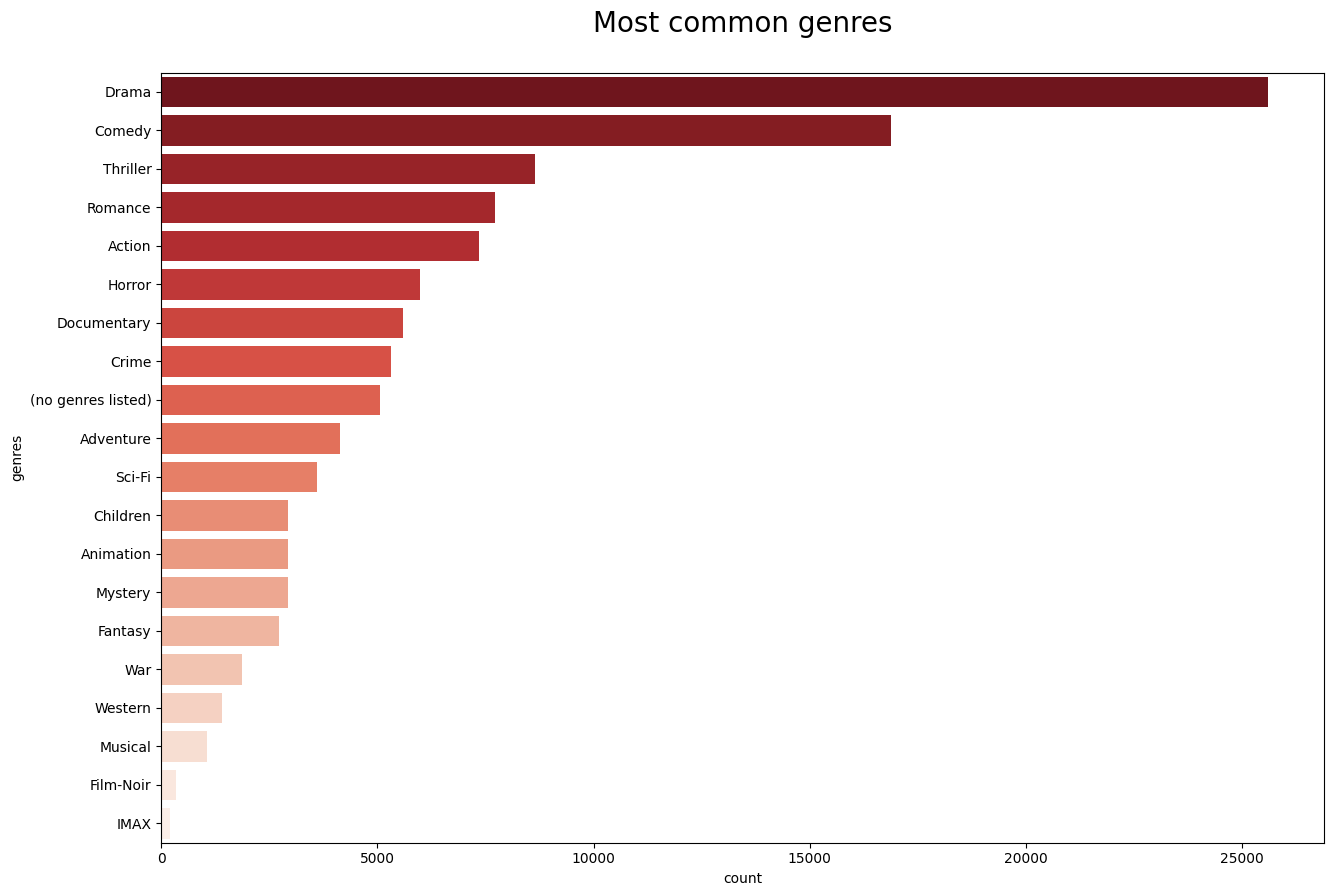

In [11]:
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

In [12]:
from surprise import accuracy
from surprise.model_selection import train_test_split

train_df_new = train_df.drop(columns="timestamp")
train_df_new.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


In [13]:
# Define the Reader and Dataset
reader = Reader(rating_scale=(0.5, 5.0))
trainset_data = Dataset.load_from_df(train_df_new[['userId', 'movieId', 'rating']][:00], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(trainset_data, test_size=0.2)

# Train the SVD model
svd = SVD()
svd.fit(trainset)

# Make predictions on the test set
predictions = svd.test(testset)

# Compute and print the RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

# Convert predictions to DataFrame
pred = pd.DataFrame([(pred.uid, pred.iid, pred.r_ui, pred.est, pred.details) for pred in predictions], 
                    columns=['userId', 'movieId', 'actual_rating', 'estimated_rating', 'details'])

# To print the DataFrame (pred)
pred

RMSE: 0.8338
RMSE: 0.8337837424189483


,userId,movieId,actual_rating,estimated_rating,details
0,10496,87234,4.0,3.809961,{'was_impossible': False}
1,137177,4016,5.0,2.973760,{'was_impossible': False}
2,29342,3328,3.0,3.377295,{'was_impossible': False}
3,150262,198763,3.0,3.311345,{'was_impossible': False}
4,28777,47629,4.0,3.996259,{'was_impossible': False}
...,...,...,...,...,...
2000003,54115,1722,4.0,3.935692,{'was_impossible': False}
2000004,124667,6283,5.0,3.730740,{'was_impossible': False}
2000005,69608,1090,5.0,4.056717,{'was_impossible': False}
2000006,78332,2,1.5,2.288070,{'was_impossible': False}


In [ ]:
pred.shape

In [15]:
# Function to get collaborative recommendations for a user profile
def get_collaborative_recommendations(svd, prediction_result=pred[:100], n=10):
    recommendations = []
    #for user_id, movie_id in zip([107599], [5954]):
    for user_id, movie_id in zip(prediction_result['userId'], prediction_result['movieId']):
        prediction = svd.predict(user_id, movie_id)
        userId, movieId, actual_rating, estimated_rating = prediction_result[(prediction_result['userId'] == user_id) & (prediction_result['movieId'] == movie_id)][['userId','movieId','actual_rating','estimated_rating']].values[0]
        movie_title = movies_df[movies_df['movieId'] == movie_id].values[0][1]
        new_recommendation = ( userId, movieId, actual_rating, estimated_rating, movie_title)
        recommendations.append(new_recommendation)

    recommendations = sorted(recommendations, key=lambda x: x[4], reverse=True)

    return recommendations[:n]

In [ ]:
# Generate recommendations for each user profile and collect them in a list
all_recommendations = []

recommendations = get_collaborative_recommendations(svd,pred[:100])
for userId, movieId, actual_rating, predicted_rating, movie_title in recommendations:
    all_recommendations.append({
            'Id': str(int(userId)) + "_" + str(int(movieId)),
            'rating': predicted_rating,
        })

# Convert the list of recommendations to a DataFrame
recommendations_df = pd.DataFrame(all_recommendations)

recommendations_df

In [ ]:
# This is an example
my_submission = pd.DataFrame({'id': recommendations_df.userId,'predict': recommendations_df.Predicted_Rating})
#you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)